### Install requirements

In [1]:
!pip install astropy emcee corner numpy scipy pandas

### Get working directory

In [2]:
!pwd

/home/jupyter


#### Import required libraries

In [3]:
import numpy as np
import pandas as pd
import scipy.integrate as int
import scipy.optimize as op
import emcee
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.constants as const
import sys
from astropy.cosmology import wCDM
#from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM
from time import time

####  Observational hubble for given redshifts


### Input the required data 

#### Chronometers

In [4]:
#inputting data
cc_xdata, cc_ydata, cc_yerr = np.loadtxt('cosmic_chrono.txt',usecols=(0,1,2), unpack=True)

#####  BAO - baryon acoustic osicalltions 

In [5]:
bao_xdata, bao_ydata, bao_yerr = np.loadtxt('bao.dat',usecols=(0,1,2), unpack=True)

##### Quasars

In [6]:
zqso0, fUV0, fUVerr0, fX0, fXerr0  = np.loadtxt('qso.txt', usecols=(3, 4, 5, 6, 7), unpack=True)


##### Megaparsec conversion?


In [7]:
fUV0 = fUV0+2*np.log10(3.086e+24)
fX0 = fX0 + 2*np.log10(3.086e+24)
np.shape(fUV0)

(2421,)

#### Merging data sets

In [8]:
input_xdata = np.append(cc_xdata, bao_xdata)
input_ydata = np.append(cc_ydata, bao_ydata)
input_yerr = np.append(cc_yerr, bao_yerr)

Density of Mater $\Omega_m$
<br>
Hubble Constant $H_0$
<br>
Redshift $Z$
<br>
Hubble Parameter for $ \Lambda $CDM $H(z)$ 



0.0 to 0.6
0.6 to 1.2
1.2 to 1.8
1.8 to 2.4

##### Restriciting Redshift to 0.7 < $z$ < 2.36

In [9]:
x = np.logical_and(0.7 < zqso0, zqso0 <= 2.36)
zqso = zqso0[x]
fUV = fUV0[x] 
fUVerr = fUVerr0[x] 
fX = fX0[x] 
fXerr = fXerr0[x]
len(zqso)

1737

In [10]:
x = np.logical_and(0.7 < input_xdata, input_xdata <= 2.36)
xdata = input_xdata[x]
ydata = input_ydata[x]
yerr = input_yerr[x]
len(yerr)

19

##### Functions 

$1/\sqrt{1-\Omega_m + \Omega_m (1+z)^3}$

In [11]:
# Z is redshift, om is mater density
def integrand(z, om):
    return 1/np.sqrt(1-om+om*(1+z)**3)

$H(z) = H_0 \sqrt{1-\Omega_m + \Omega_m (1+z)^3}$

In [12]:

# Z - Redshift 
# h0 - Hubble
# Mater Density
# Define of hubble parameter
def H(z, h0, om):
    return h0*np.sqrt(1-om + om*(1+z)**3)



#### Luminoisty Distance 
$D_{L}(z) = c (1+z) \int_{0}^{z} \frac{1}{H(z^{\prime})}  z^{\prime}$

In [13]:
# Integratal of 1/h(z) 
# Luminousity distance
def DL(z, h0, om):
    ans = const.c*(1+z)/1000/h0*int.quad(integrand, 0.0, z, args =(om))[0]    
    return ans

# Vectorising for array
DL = np.vectorize(DL)

#### Likelihood
$ \mathcal{L} = - \frac{1}{2} \sum_{i=1}^N \left[ \frac{ (\log_{10} F_{X,i}^{\textrm{obs}} - \log_{10} F_{X,i}^{\textrm{model}})^2}{s_i^2} + \ln (2 \pi s_i^2)\right]$

In [14]:
# Negative of Chi-Square
# Likelyhood 
def lnlike(u):
    h0 = u[0]
    om = u[1]
    # scale for h(0) - calibration
    beta = u[2]
    # 
    gamma = u[3]
    delta = u[4]
   
    # left hand side of equation 18 
    temp = beta+(gamma-1)*np.log10(4*np.pi*DL(zqso, h0, om)**2)+gamma*fUV
    
    #Likelyhood - equation 19
    qso = -1/2*((temp-fX)**2/(fXerr**2+delta**2)+np.log(2*np.pi*(fXerr**2+delta**2))).sum()
    
   
    # BAO + CC 
    cc = -1/2*((ydata-H(xdata, h0, om))**2/yerr**2).sum()
    
    # Planck prior 
    wm = om*(h0/100)**2
    
    
    cmb = -1/2*(wm - 0.1430)**2/0.00000121
    
    # Adding all negative chi-squares
    return qso+cmb+cc

##### Negating 
#####  [70, 0.3, 7, 0.6, 0.2] - Initial guess


In [15]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, [70, 0.3, 7, 0.6, 0.2], 
                     bounds = ((0.001, 100), (0,1), (0.001, 15), (0.001,1), (0.001,1)), 
                     options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-15, 'gtol': 1e-05, 'eps': 1e-08, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20})

h0, om, b, g, d = result["x"]
print(h0, om, b, g, d)


37.84740074013285 1.0 8.359391737413675 0.601227012834116 0.23032140734774104


##### Prior
$(H_0/100)^2\Omega_m $

In [16]:
print("Prior: "+str((h0/100)**2*om))

Prior: 0.14324257427842083


##### Impose bounds

In [17]:
def lnprior(u):
    h0 = u[0]
    om = u[1]
    beta = u[2]
    gamma = u[3]
    delta = u[4]

    if 0 < h0 < 100 and 0 < om < 1 and 0 < b < 15 and 0 < gamma < 1 and 0 < delta < 1: 
        return 0.0
    return -np.inf

#### Implement the bounds

In [18]:
def lnprob(u):
    lp = lnprior(u)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(u)

#### Markov Chain Monte Carlo Simulation

In [19]:
from multiprocessing import Pool

In [20]:
ndim, nwalkers = 5, 30
pos = [[h0, om, b, g, d] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [21]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    sampler.run_mcmc(pos, 100000, progress=True);

  0%|          | 0/100000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 68%|██████▊   | 67978/100000 [2:28:21<1:14:55,  7.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 89%|████████▉ | 89275/100000 [3:14:31<20:23,  8.77it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
tau = sampler.get_autocorr_time()
print(tau)

[1155.19224591  932.10615913  169.87993321  156.07111783  120.66045842]


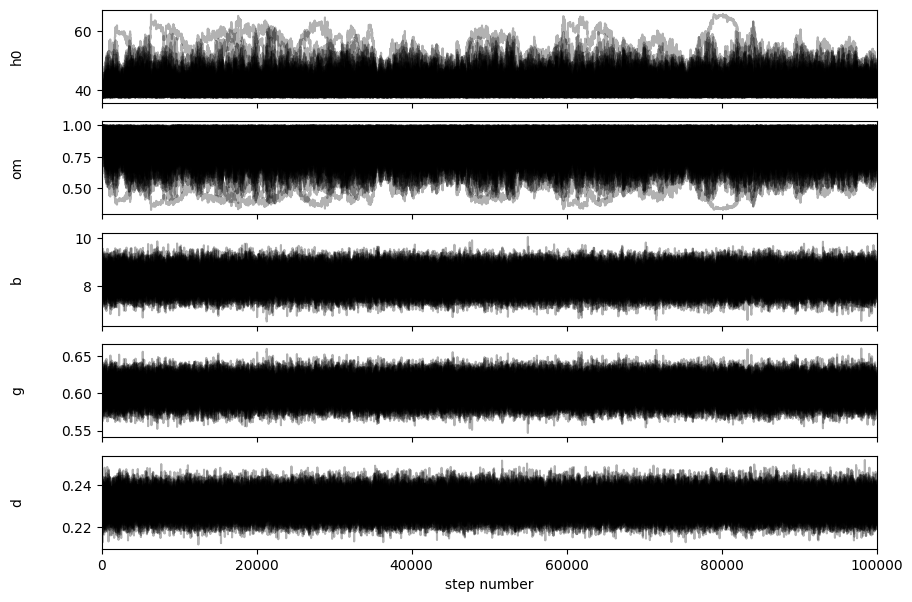

In [23]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["h0", "om", "b", "g", "d"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
samples = sampler.chain[:, 750:, :].reshape((-1, ndim))

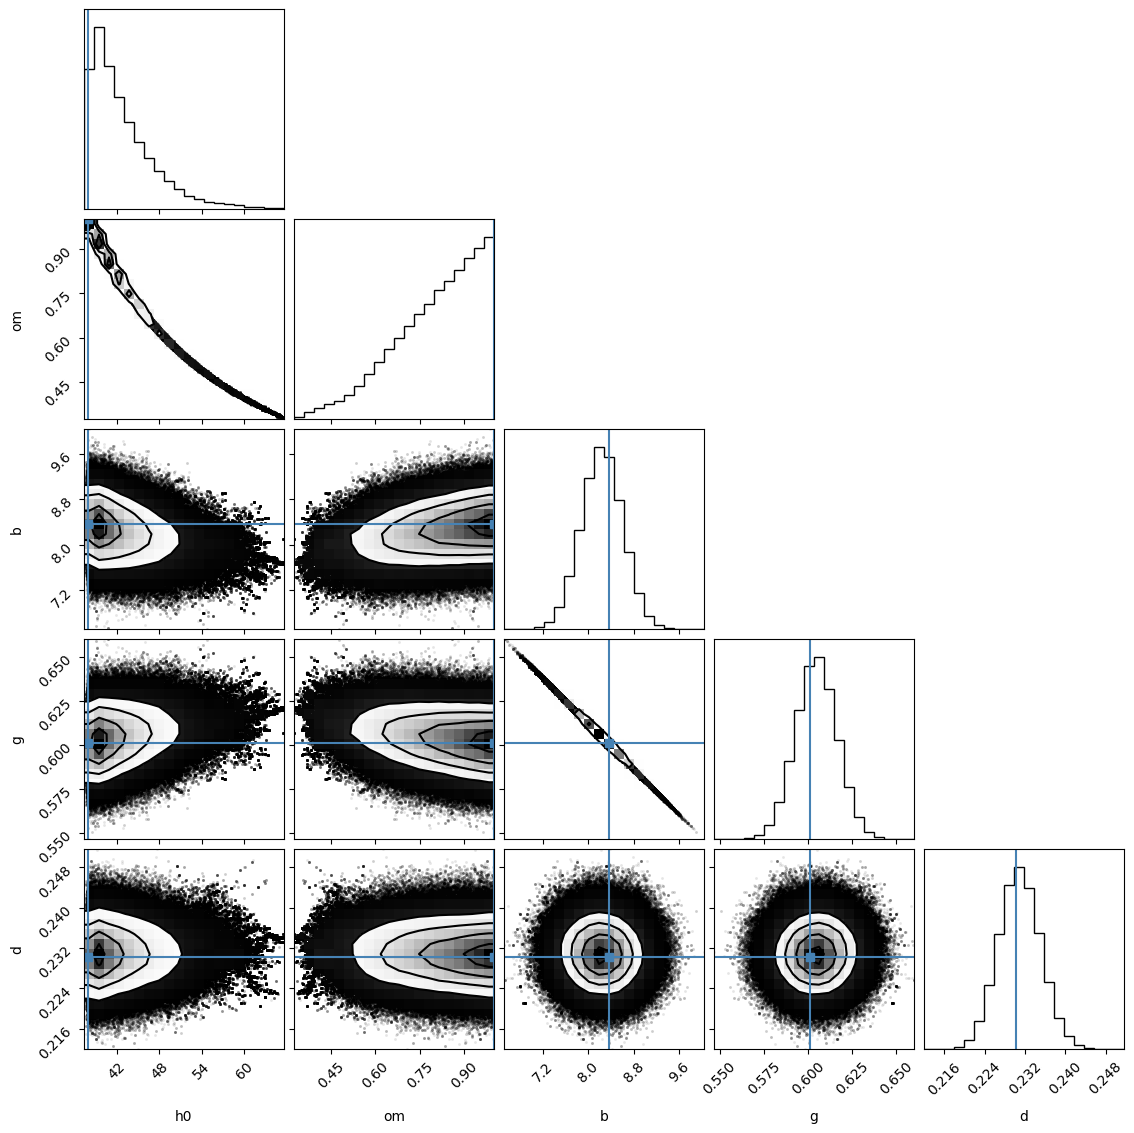

In [25]:
import corner
fig = corner.corner(samples, labels=["h0", "om", "b", "g", "d"], truths=[h0, om, b, g, d])
#fig.savefig("QSO_OHD_CMBprior_zmax07.png")

In [26]:
flat_samples = sampler.get_chain(discard=750, thin=15, flat=True)
print(flat_samples.shape)

(198480, 5)


In [27]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    #err = 1/2*(q[0]+q[1])
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #txt = "\mathrm{{{2}}} = {0:.2f}\pm{{{1:.2f}}}"
    #txt = txt.format(mcmc[1], err, labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Save the chains

In [28]:
np.savetxt("QSO_OHD_CMBprior_zmax0_MCMCchain_"+str(time())+".txt", flat_samples)